# Imports

In [16]:
import gradio as gr
import torch
import uuid
import os
from diffusers import StableDiffusionPipeline
from IPython.display import display
from PIL import Image
import requests
from dotenv import load_dotenv

# Set up Stable Diffusion pipeline

In [17]:
hf_model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
pipe = StableDiffusionPipeline.from_pretrained(hf_model_id, torch_dtype=torch.float16 if device=="cuda" else torch.float32)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Style prompt builder

In [19]:
def style_prompt(base_prompt, style):
    style_mods = {
        "Anime": "anime style, cel-shading, sharp lines, vibrant colors",
        "Realistic": "realistic, highly detailed, cinematic lighting",
        "Pixel Art": "pixel art, 8-bit, retro style"
    }
    return f"{base_prompt}, {style_mods.get(style, '')}"

# Generate character lore using EdenAI

In [20]:
load_dotenv()
api_key = os.getenv("EDENAI_API_KEY")

def generate_lore(prompt):
    url = "https://api.edenai.run/v2/text/generation"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    payload = {
        "providers": "openai",
        "text": f"Create a character profile for: {prompt}. Include name, 3 traits, a short personality summary, and backstory.",
        "temperature": 0.7,
        "max_tokens": 200
    }

    response = requests.post(url, json=payload, headers=headers)
    result = response.json()

    try:
        return result["openai"]["generated_text"]
    except KeyError:
        return "Error: Could not generate lore. Check provider response."

# Combine image generation and lore generation into a single function

In [21]:
def generate_character(prompt, style):
    full_prompt = style_prompt(prompt, style)
    image = pipe(full_prompt).images[0]

    lore = generate_lore(prompt).strip()
    
    # Save outputs
    save_id = str(uuid.uuid4())
    save_folder = "characters"
    os.makedirs(save_folder, exist_ok=True)
    image_path = os.path.join(save_folder, f"{save_id}.png")
    text_path = os.path.join(save_folder, f"{save_id}.txt")

    image.save(image_path)
    with open(text_path, "w") as f:
        f.write(lore)

    return image, lore

# Test

  0%|          | 0/50 [00:00<?, ?it/s]

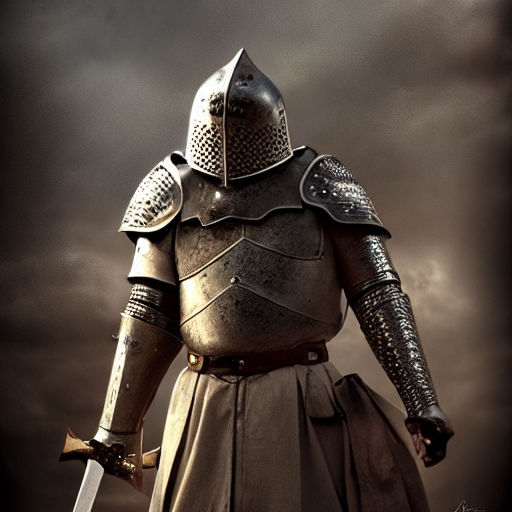


Character Lore:

Name: Sir Galen

Traits:
1. Courageous: Sir Galen is known for his bravery on the battlefield, fearlessly charging into battle against seemingly unbeatable odds.
2. Mysterious: Despite his reputation as a great knight, not much is known about Sir Galen's past. He keeps to himself and rarely speaks of his personal life.
3. Loyal: Sir Galen is fiercely loyal to his king and will do anything to protect his kingdom and its people.

Personality Summary:
Sir Galen is a stoic and determined knight, always ready to face any challenge that comes his way. He is a man of few words, preferring to let his actions speak for him. His loyalty and bravery make him a respected figure among his fellow knights, but his mysterious past adds an air of intrigue to his character.

Backstory:
Sir Galen's past is shrouded in mystery. Some say he was a commoner who rose through the ranks with his exceptional skill


In [ ]:
def test_generate_character():
    image, lore = generate_character("A brave knight with a mysterious past", "Realistic")
    
    if image:
        display(image)
    else:
        print("Image generation failed.")
    
    print("Character Lore:\n")
    print(lore)

test_generate_character()

# Using Web UI

In [23]:
with gr.Blocks() as demo:
    gr.Markdown("# 🧙 AI Character Generator")

    with gr.Row():
        user_input = gr.Textbox(label="Describe your character (appearance, personality, etc.)")
        style_choice = gr.Dropdown(["Anime", "Realistic", "Pixel Art"], label="Image Style", value="Anime")

    generate_button = gr.Button("Generate")
    image_output = gr.Image(label="Generated Image")
    lore_output = gr.Textbox(label="Character Profile", lines=8)

    generate_button.click(fn=generate_character, inputs=[user_input, style_choice], outputs=[image_output, lore_output])

In [24]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
